In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Bayesian General Linear Models

Bayes Theorem and Bayesian inference is used to determine posterior probability distributions. 

Here, Bayesian Inference is applied to a General Linear Model (GLM) for regression. 

### The Model
The objective is to *develop a model to predict student grades* given several input factors for student demographics. The publicly avaliable [UCI dataset](https://archive.ics.uci.edu/ml/datasets/student+performance#) contains grades and factors for 649 students taking a Portugese language course. 

In [2]:
os.listdir('./data')
raw = pd.read_csv('./data/student-por.csv',sep=';')

**Dependent variable or "Target"**
- "G3" is the students final grade for portugese (numeric: from 0 to 20, output target)

***Independent variables or "Features"***

A subset of numeric and categorical features is used to build the initial model:
- "age" student age from 15 to 22
- "internet"  student has internet access at home (binary: yes or no)
- "failures" is the number of past class failures (cat: n if 1<=n<3, else 4) 
- "higher" wants to take higher education (binary: yes or no) 
- "Medu" mother's education (cat: 0 - none, 1 - primary education (4th grade), 2 5th to 9th grade, 3 secondary education or 4 higher education)
-  ""Fedu father's education (cat: 0 - none, 1 - primary education (4th grade), 2 5th to 9th grade, 3 secondary education or 4 higher education)
-  "studytime" weekly study time (cat: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- "absences" number of school absences (numeric: from 0 to 93) 

In [3]:
# prep Xy data
df = raw.loc[~raw['G3'].isin([0])].copy()
print(df.shape)

# prep features
categoricals = ['internet','higher']
reals = ['age','absences','failures','Medu','Fedu','studytime']
features = categoricals+reals
target = ['G3']
for cat in categoricals: 
    df[cat] = df[cat].map({'no':0,'yes':1})
df = df[features+target].copy()
df[:1]

(634, 33)


,internet,higher,age,absences,failures,Medu,Fedu,studytime,G3
0,0,1,18,4,0,4,4,2,11


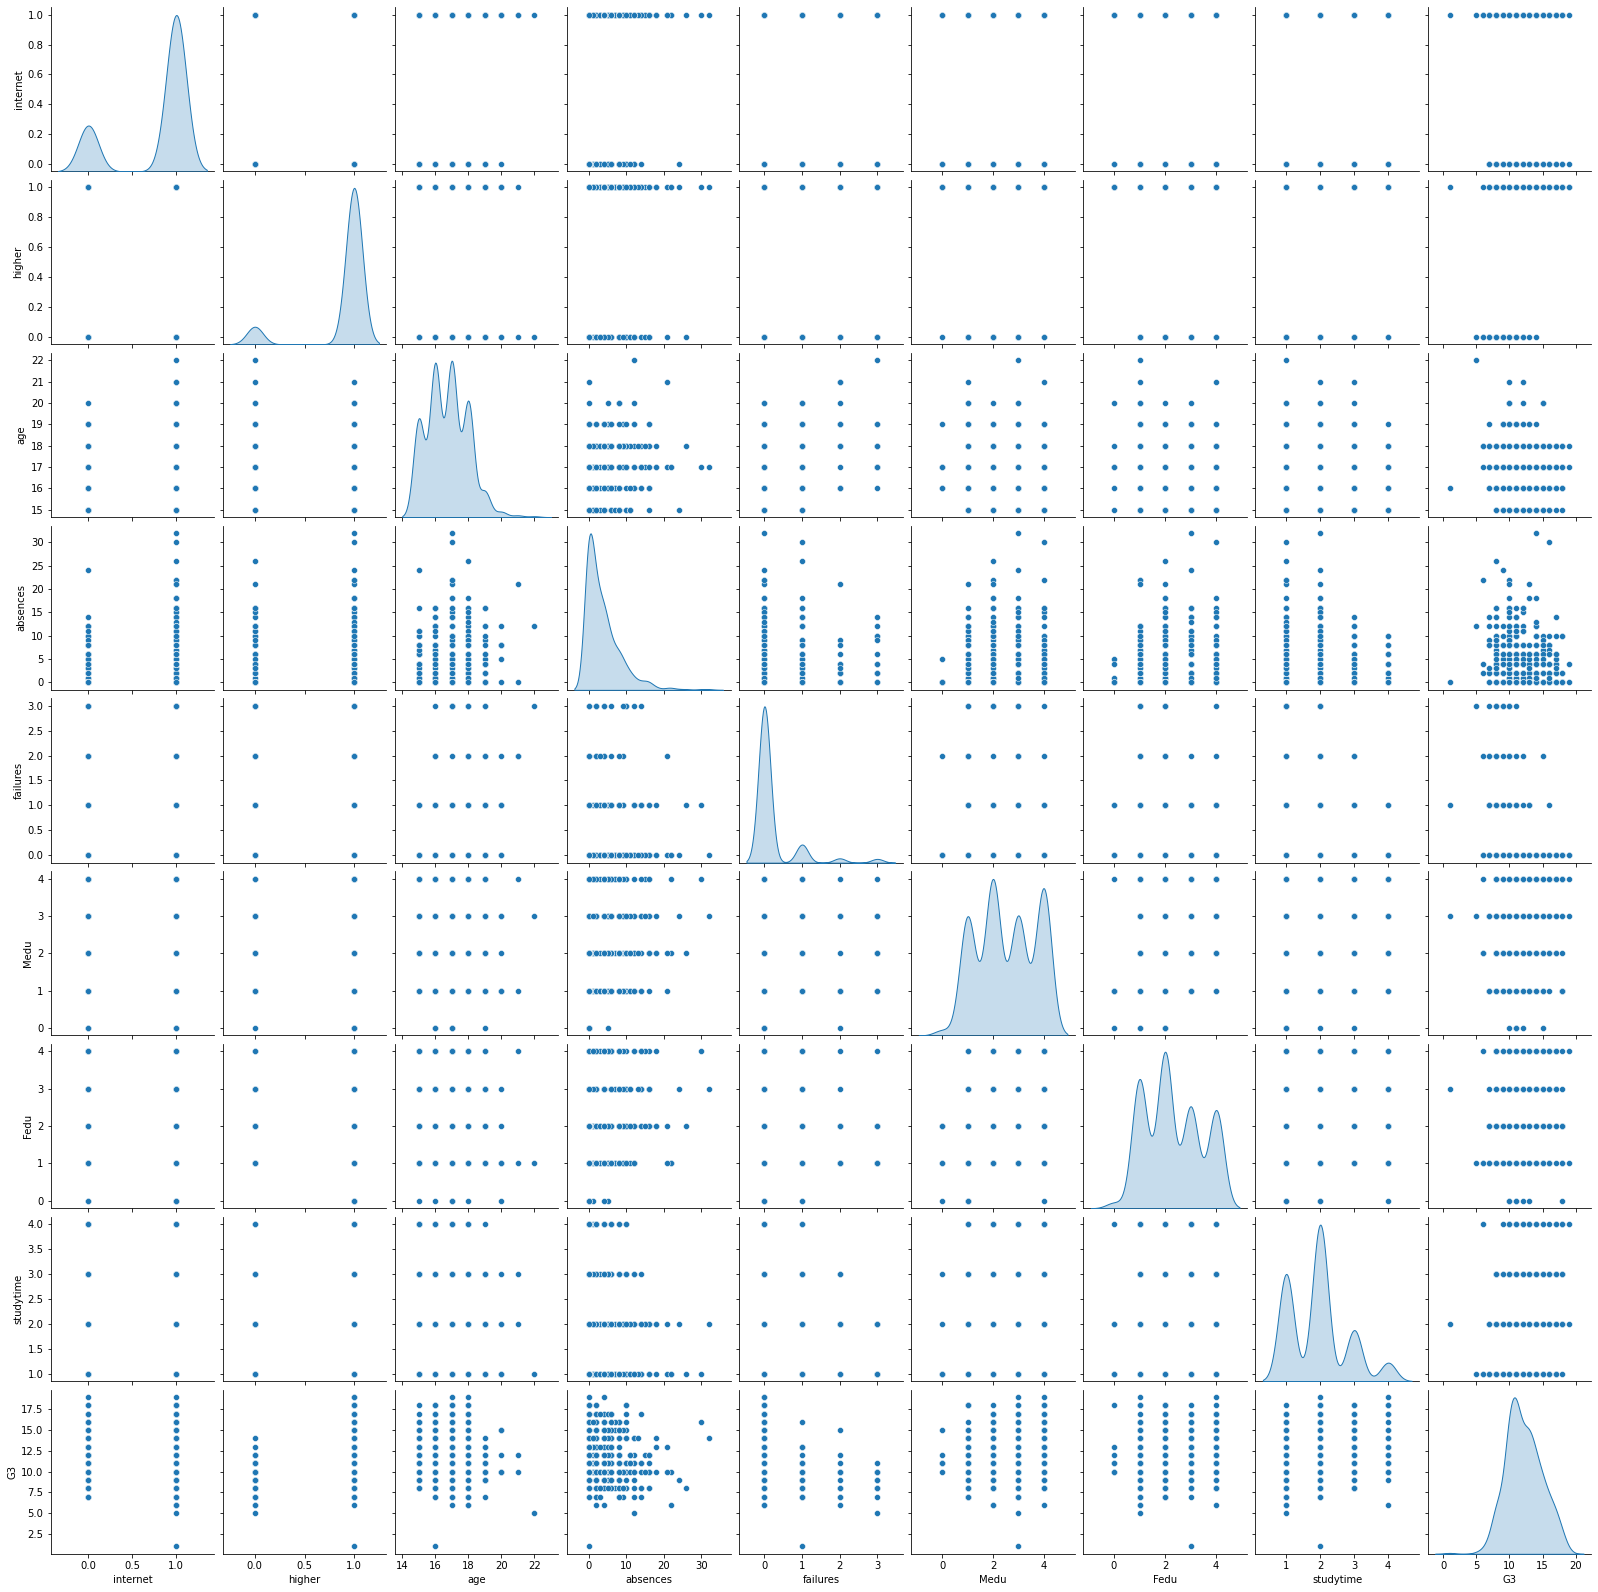

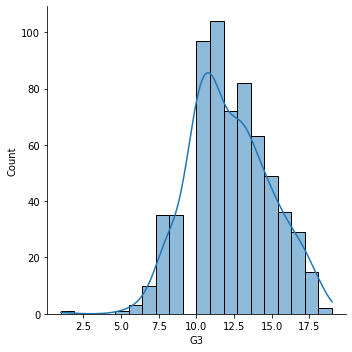

In [4]:
sns.pairplot(data=df,diag_kind='kde')
sns.displot(data=df,x='G3',kde=True);

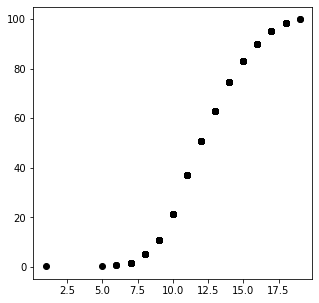

In [5]:
# grade percentiles
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html
from scipy import stats
df['grade_percentile'] = df['G3'].apply(lambda x: stats.percentileofscore(df['G3'],x))
plt.figure(figsize=(5,5))
plt.scatter(df['G3'],df['grade_percentile'],c='k');

### GLM 

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot

Quick recap on OLS or Gaussian GLM.
- Guassian GLm predicts mean value Y (Ymu) given constant scale.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  200
Model:                            GLM   Df Residuals:                      198
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          1.1378
Method:                          IRLS   Log-Likelihood:                -295.70
Date:                Fri, 12 Mar 2021   Deviance:                       225.29
Time:                        11:26:27   Pearson chi2:                     225.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9596      0.279     -3.435      0.0

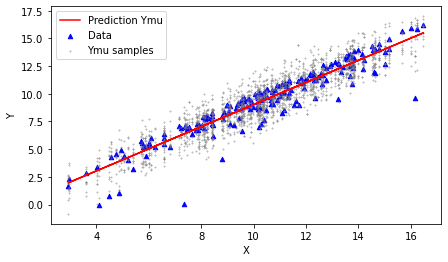

In [7]:
# recap on gaussian model
fig,axs = plt.subplots(1,1,figsize=(7,4))

# dummy data
n = 200
Xy = pd.DataFrame({'X':np.random.normal(loc=10,scale=3,size=n)})
Xy['y'] = Xy.X - np.random.gamma(shape=1,scale=1,size=n)

axs.scatter(Xy.X,Xy.y,c='blue',s=20,marker='^',label='Data')

# fit model
Xym = smf.glm(formula='y~X',data=Xy).fit()
print(Xym.summary())

# prediction : plot mean
Xy['P'] = Xym.predict()
axs.plot(Xy.X,Xy.P,c='red',label='Prediction Ymu')

# predictions : plot 10 samples of model mean with standard deviation
for r in range(10):
    a = np.random.normal(loc=Xy.P,scale=Xym.scale)
    axs.scatter(Xy.X.values,a,marker='x',c='grey',s=1,alpha=0.5)
axs.scatter(Xy.X.values,a,marker='x',c='grey',s=1,alpha=0.5,label='Ymu samples')
axs.set_xlabel('X')
axs.set_ylabel('Y')
    
axs.legend();

Other than age, most features in this dataset have been cut into categories. I could convert the values into objects so that our modelling packages identify and treat variables appropriately. Alternatively in statsmodels formula we can directly specify the categorical variables by "C(categorical_feature)".

In [8]:
# model grade data
formula = [f"{f}" if f not in categoricals else f"C({f})" for f in features]
formula = f'{target[0]} ~ ' + ' + '.join(formula)
glm_ = smf.glm(formula=formula,
              data=df,
              family=sm.families.Gaussian())
glm = glm_.fit()
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     G3   No. Observations:                  634
Model:                            GLM   Df Residuals:                      625
Model Family:                Gaussian   Df Model:                            8
Link Function:               identity   Scale:                          5.1895
Method:                          IRLS   Log-Likelihood:                -1417.1
Date:                Fri, 12 Mar 2021   Deviance:                       3243.4
Time:                        11:26:27   Pearson chi2:                 3.24e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.6741      1.430      2.570      0.010       0.872       6.476
C(internet)[T.1]     0.2882      0.225      1.282      0.200      -0.152       0.729
C(higher)[T.1]       1.8413      0.328      5.622      0.000       1.199       2.483
age                  0.3185      0.081      3.945      0.000       0.160       0.477
absences            -0.0739      0.020     -3.674      0.000      -0.113      -0.034
failures            -1.4217      0.170     -8.339      0.000      -1.756      -1.088
Medu                 0.3847      0.108      3.567      0.000       0.173       0.596
Fedu                 0.0332      0.108      0.306      0.760      -0.179       0.246
studytime            0.4307      0.112      3.839      0.000       0.211       0.651
====================================================================================
"""

In [9]:
from sklearn import metrics

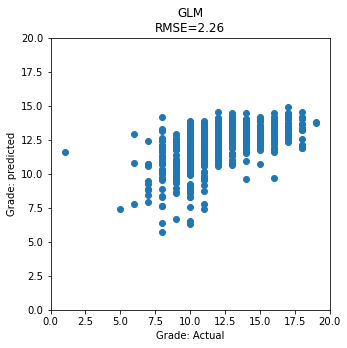

In [10]:
fig,axs = plt.subplots(1,1,figsize=(5,5))

yhat = glm.predict(df)
rmse = np.sqrt(np.mean((yhat - df[target].values.reshape(-1,))**2))
rmse = metrics.mean_squared_error(df[target],yhat,squared=False)

axs.scatter(df[target],yhat)
axs.set_title(f'GLM\nRMSE={rmse:.2f}')
axs.set_xlabel('Grade: Actual')
axs.set_ylabel('Grade: predicted')
axs.set_xlim(0,20)
axs.set_ylim(0,20);

## PyMC3 GLM

Now lets re-build our GLM model using PyMC3. This [post](https://twiecki.io/blog/2013/08/12/bayesian-glms-1/) is the official guide.

In [11]:
import pymc3 as pm
import arviz as avz

In [12]:
# note we can re-use our formula 
formula

'G3 ~ C(internet) + C(higher) + age + absences + failures + Medu + Fedu + studytime'

In [13]:
bglm = pm.Model()
with bglm:
    # Normally distributed priors
    family = pm.glm.families.Normal()
    
    # create the model 
    pm.GLM.from_formula(formula,data=df,family=family)
    
    # sample
    trace = pm.sample(1000,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, studytime, Fedu, Medu, failures, absences, age, C(higher)[T.1], C(internet)[T.1], Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


Once the model has run we can examine the model posterior distribution samples. This is akin to viewing the ```model.summary()``` of a classic linear model. Here the mean is the estimate of the feature distribution. In our case the model intercept mean is around 4.9, meaning a student is expected to attain at least a grade of 4.9 irrespective of what we know about them. 

The 3-97% highest posterior density "hpd" range indicates the credible interval for the true value of our parameter. As for classical models if this range crosses 0, from negative effect to positive effect, then perhaps the data signal is too weak to draw conclusions for this variable. This is the case for Internet usage - darnit Covid19. 

[**NOTE** in January 2021 Pymc3 updated many plotting feature to arviz](https://github.com/pymc-devs/pymc3/blob/master/RELEASE-NOTES.md#pymc3-3110-21-january-2021)

```
# where
pm.summary()

# becomes
arviz.summary()
```

the data type output of pm.sample() is also now the cross platform [InferenceData](https://arviz-devs.github.io/arviz/schema/schema.html) class.

```
t = trace['posterior']
t.data_vars.variables['Intercept'].mean()
```

In [14]:
summary = avz.summary(trace)
summary[:5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.633,1.492,0.836,6.391,0.029,0.021,2720.0,2677.0,1.0
C(internet)[T.1],0.294,0.224,-0.120,0.716,0.003,0.003,4451.0,2761.0,1.0
C(higher)[T.1],1.847,0.333,1.274,2.523,0.005,0.004,4051.0,2906.0,1.0
age,0.320,0.085,0.154,0.468,0.002,0.001,2794.0,2682.0,1.0
absences,-0.074,0.020,-0.111,-0.036,0.000,0.000,4465.0,3061.0,1.0


The posterior distributions can also be viewed via traceplots. 

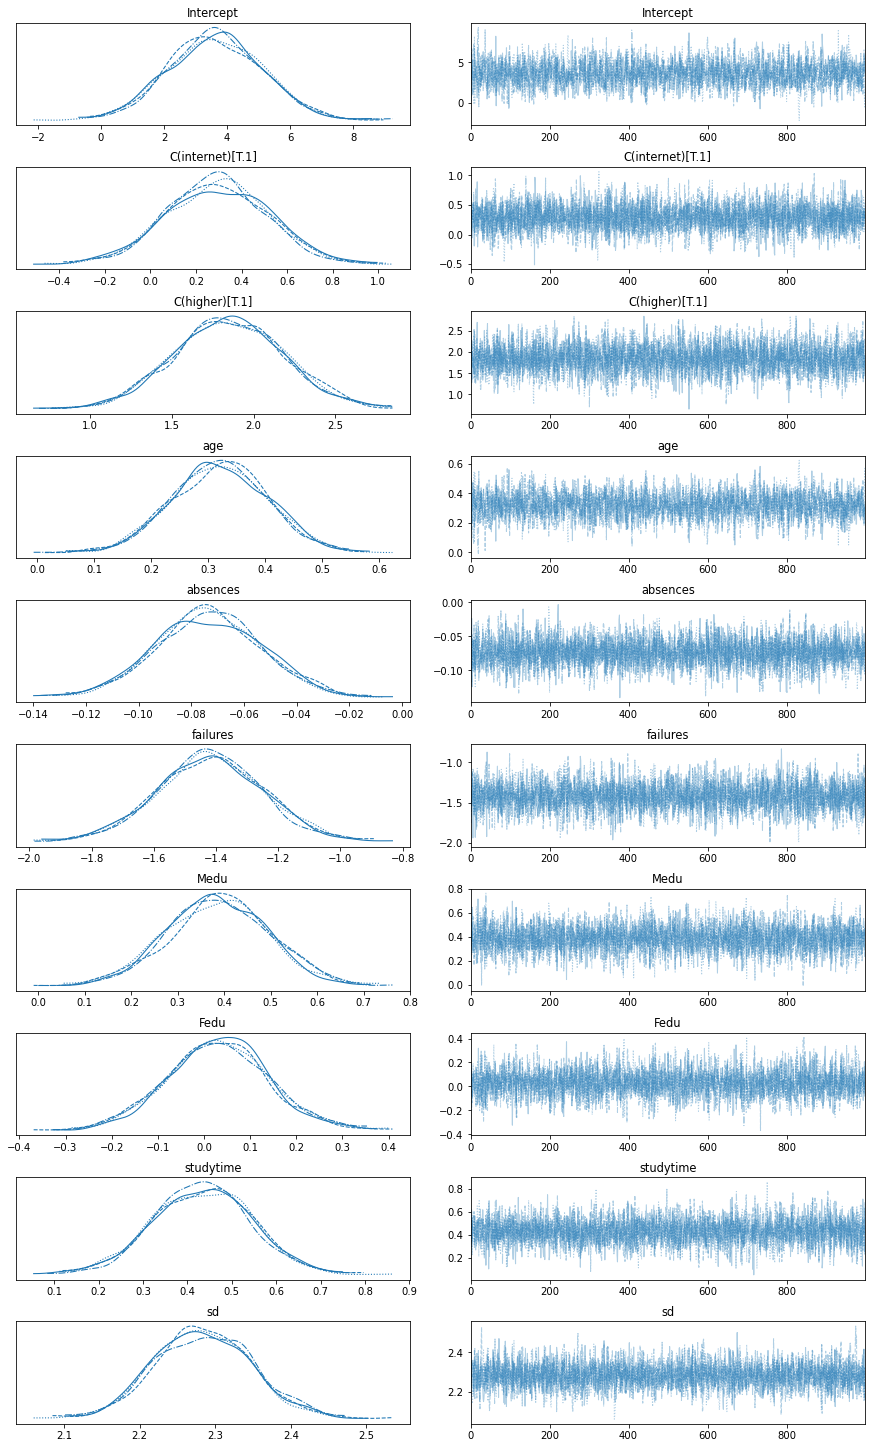

In [15]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    avz.plot_trace(trace)
    
# alternatively via the posterior plot function
# pm.plot_posterior(trace);

## Interpret Variable effect on Predicted Grade

In [16]:
# Examines the effect of changing a single variable
# Takes in the name of the variable, the trace, and the data
def model_effect(query_var, trace, X):
    
    # Variables that do not change
    steady_vars = list(X.columns)
    steady_vars.remove(query_var)
    
    # Linear Model that estimates a grade based on the value of the query variable 
    # and one sample from the trace
    def lm(value, sample):
        
        # Prediction is the estimate given a value of the query variable
        prediction = sample['Intercept'] + sample[query_var] * value
        
        # Each non-query variable is assumed to be at the median value
        for var in steady_vars:
            
            # Multiply the weight by the median value of the variable
            prediction += sample[var] * X[var].median()
        return prediction
    
    
    # Find the minimum and maximum values for the range of the query var
    var_min = X[query_var].min()
    var_max = X[query_var].max()
    
    # Plot the estimated grade versus the range of query variable
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                     lm=lm, samples=100, color='blue', 
                                     alpha = 0.4, lw = 2)
    
    # Plot formatting
    plt.xlabel('%s' % query_var, size = 16)
    plt.ylabel('Grade', size = 16)
    plt.title("Posterior of Grade vs %s" % query_var, size = 18)
    plt.show()

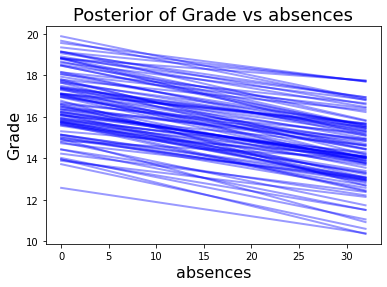

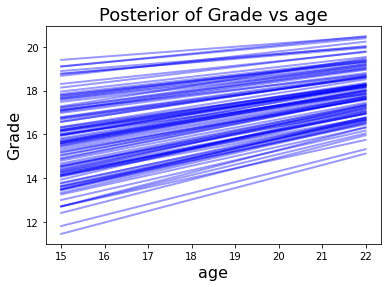

In [17]:
X = pd.DataFrame(data=glm_.data.exog,columns=glm_.data.param_names) # dmatrix
model_effect('absences',trace,X)
model_effect('age',trace,X)

## Posterior Predictive Checks 
[Posterior predictive checks (PPCs)](https://docs.pymc.io/notebooks/posterior_predictive.html) and [sample_posterior_predictive()](https://docs.pymc.io/api/inference.html#pymc3.sampling.sample_posterior_predictive) provide sampling over the fitted trace of model parameters. As per the PyMC3 docs prior predictive checks are also a crucial part of the Bayesian modeling workflow. Basically, they have two main benefits:

- *They allow you to check whether you are indeed incorporating scientific knowledge into your model – in short, they help you check how credible your assumptions before seeing the data are.*
- *They can help sampling considerably, especially for generalized linear models, where the outcome space and the parameter space diverge because of the link function.*


Below, sampling is used to sample the Y outcome of our model *n* times (left). The KDE plot the of observed true Y is shown for comparison. Similar to the above trace plots, PPC can also provide specific sampling of model parameters such as Age (right).

/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<AxesSubplot:title={'center':'PPC a\nsamples=200'}, ylabel='Density'>

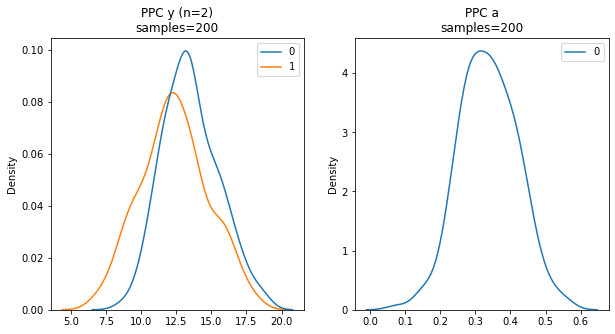

In [18]:
# this samples the posterior distribution predictions on the train set
fig,axs = plt.subplots(1,2,figsize=(10,5))

n = 2
samples = 200
var = 'y'
axs[0].set_title(f"PPC {var} (n={n})\nsamples={samples}")
with bglm:
    p = pm.sample_posterior_predictive(trace,
                                       samples=samples,
                                       model=bglm,
                                       var_names=[var])
sns.kdeplot(data=pd.DataFrame(p[var][:,:n]),ax=axs[0])

# this samples the posterior coefficient distributions 
# for either Y or a specific var_name
var = 'age'
axs[1].set_title(f"PPC {var[0]}\nsamples={samples}")
with bglm:
    p = pm.sample_posterior_predictive(trace,
                                       samples=samples,
                                       model=bglm,
                                       var_names=[var])
sns.kdeplot(data=pd.DataFrame(p[var]),ax=axs[1])

## Predictions on Out-Of-Sample (OOS) data

Now that the model is trained and fitted on the data and we have inspected variable effects we can use the model to make predictions on out of sample observations and test cases. In contrast to other modelling approaches and packages, such as statsmodels and scikit-learn, it is not as straight forward as simply calling ```model.predict(Xdata)```. In PyMC3 I have discovered several strategies for applying models to out-of-sample data. 


### method 1: the mean coefficient model
We can use the MCMC trace to obtain a sample mean of each model coefficients and use this to re-construct a typical GLM formula. Remember we used statsmodels-patsy formulation to encode our categorical variables, well we can again use patsy to construct a helper. 

The benefit to this approach is its ease and simplicity. But the downside is that we are now omitting and missing out on a chunk of that MCMC sampling for the confidence and uncertaintiy in our data that we obtained by taking a Bayes approach in the first place. 

In [19]:
# mean model coefficients
mean_model = summary[['mean']].T.reset_index(drop=True)

# create a  design matrix of exog data values
# same as for GLM's
X = pd.DataFrame(data=glm_.data.exog,columns=glm_.data.param_names)

# add columns for the standard deviations output from the bayesian fit
for x in mean_model.columns:
    if x not in X.columns:
        X[x] = 1
        
# multiply and work out mu predictions
coefs = X * mean_model.values
pred_mu = coefs.iloc[:,:-1].sum(axis=1)[:]
pred_sd = coefs['sd']
print('Predictions:')
n = 5
for m,s in zip(pred_mu[:n],pred_sd[:n]): print(f"\tMu:{m:.2f} Sd:{s:.2f}")

Predictions:
	Mu:13.48 Sd:2.28
	Mu:12.35 Sd:2.28
	Mu:11.41 Sd:2.28
	Mu:13.48 Sd:2.28
	Mu:12.72 Sd:2.28


 ***NOTE: there is a conflict between Jupyter, pymc3.GLM and Theano***

At the time of writing this is where things with ```pm.GLM.from_formula()``` start to break down using Jupyter. The following two methods are recommended in the PyMC3 documentaiton however both generate the following Theano error when used in conjunction with ```GLM.from_formula()``` on Jupyter. 


```ERROR! Session/line number was not unique in database. History logging moved to new session 11``` 

This seems to be an issue with the way GLM.from_formula() uses patsy and interacts with Theano in Jupyter Notebooks.<br>
[_source code_](https://github.com/pymc-devs/pymc3/blob/master/pymc3/glm/linear.py#L101)<br>
[_question on SO_](https://stackoverflow.com/questions/50369957/dependency-between-session-line-number-was-not-unique-in-database-error-and-p)

I have not tested running either of the following methods using a .py script but it seems reasonable that they would work outside Jupyter.

### method 2: using Theano shared variable

For now we will loose GLM.from_formula() and create a simple model using both: patsy to generate a design matrix, and Theano to create a shared X variable.
To keep things short I have simplified my Betas using ```shape(n)``` however this will degrade model tuning performance as all priors are set at uniform initial value. It could also lead to errors [e.g see here](https://discourse.pymc.io/t/mass-matrix-contains-zeros-on-the-diagonal/4981). In practice you should set these individually using informative priors. 


In [20]:
import patsy
from theano import shared

In [21]:
print(formula)
design = patsy.dmatrices(formula_like=formula,data=df,return_type='dataframe')
# design[1].design_info

train,test = df[:500],df[500:]
trainy = patsy.build_design_matrices([design[0].design_info],train,return_type="dataframe")[0].values.reshape(-1)
trainx = patsy.build_design_matrices([design[1].design_info],train,return_type="dataframe")[0]
testy = patsy.build_design_matrices([design[0].design_info],test,return_type="dataframe")[0].values.reshape(-1)
testx = patsy.build_design_matrices([design[1].design_info],test,return_type="dataframe")[0]

# drop intercept
trainx.drop(labels=['Intercept'],axis=1,inplace=True)
testx.drop(labels=['Intercept'],axis=1,inplace=True)

print("Train-Test X shape:",trainx.shape,testx.shape)

# Shared theano variable for modelling
# must be np.array()
modelx = shared(np.array(trainx))

G3 ~ C(internet) + C(higher) + age + absences + failures + Medu + Fedu + studytime
Train-Test X shape: (500, 8) (134, 8)


In [22]:
bglm = pm.Model()
with bglm:
    
    # Priors 
    alpha = pm.Normal('alpha', mu=4, sd=10)
    betas = pm.Normal('beta', mu=1, sd=6, shape=8)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Expected value of outcome (aka linear formula)
    mu = alpha + pm.math.dot(betas, modelx.T)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=trainy)
    
    # sample   
    trace = pm.sample(1000,init="adapt_diag",return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8828326996277431, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895546042301387, but should be close to 0.8. Try to increase the number of tuning steps.


Now we can update our shared X variable with the test set and use the model to make predictions. Prediction here really means sampling the posterior distributions of each coefficient on the test set observations.

We can specify the number of sampling rounds to perform and visualise individual samples and aggregates of samples.

/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


(50, 134)


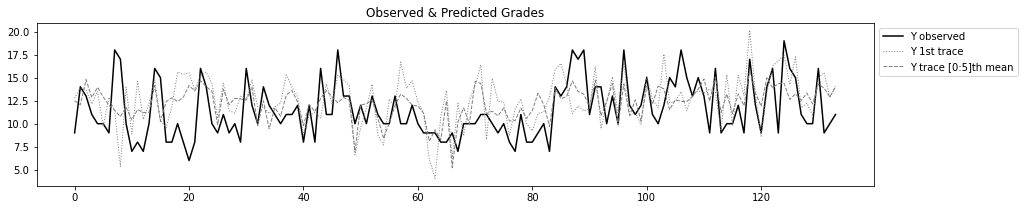

In [23]:
samples = 50

# Update model X and make Prediction
modelx.set_value(np.array(testx)) # update X data
ppc = pm.sample_posterior_predictive(trace, model=bglm, samples=samples,random_seed=6)
print(ppc['y'].shape)

n = 5
plt.figure(figsize=(15,3))
plt.title('Observed & Predicted Grades')
plt.plot(test.reset_index()['G3'],'k-',label='Y observed')
plt.plot(ppc['y'][0,:],lw=1,linestyle=':',c='grey',label='Y 1st trace')
plt.plot(ppc['y'][:n,:].mean(axis=0),lw=1,linestyle='--',c='grey',label=f'Y trace [0:{n}]th mean')
plt.legend(bbox_to_anchor=(1,1));

### method 3: shared X variable

This method is very similar above but instead using the ```pm.Data()``` to hold our X data in train and test rounds. Functionally this is cleaner as we dont need to import and use Theano ```shared()``` explicitly.

In [24]:
bglm = pm.Model()
with bglm:
    
    # Priors 
    alpha = pm.Normal('alpha', mu=4, sd=10)
    betas = pm.Normal('beta', mu=1, sd=6, shape=8)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    xdata = pm.Data("pred", trainx.T)
    
    # Expected value of outcome (aka linear formula)
    mu = alpha + pm.math.dot(betas, xdata)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=trainy)
    
    # sample   
    trace = pm.sample(1000,init="adapt_diag",return_inferencedata=True)

with bglm:
    # update values of predictors:
    pm.set_data({"pred": testx.T})
    
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["y"], samples=600)
    model_preds = posterior_predictive["y"]

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8894105468812549, but should be close to 0.8. Try to increase the number of tuning steps.
/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Again, lets increase the number of samples visualise the:

- posterior distribution of predictions for each individual observation in the OOS test data (left)
- and the Observed, Mean, Credible-Interval or "Highest Density Interval" using arviz ```hdi()```. 

/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


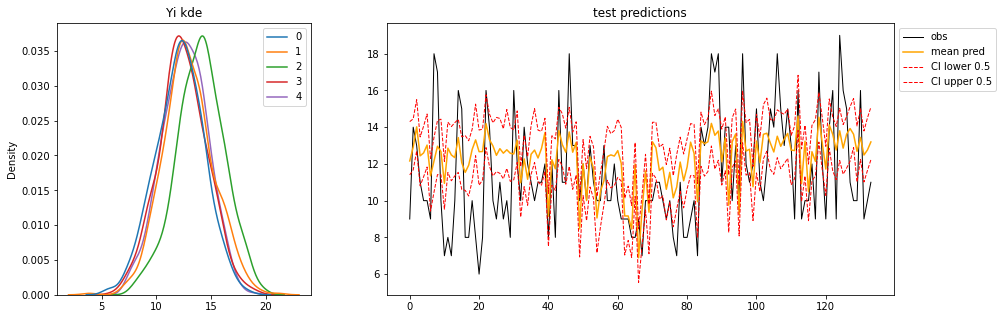

In [25]:
from matplotlib.gridspec import GridSpec

fig=plt.figure(figsize=(15,5))
gs=GridSpec(nrows=1,ncols=2,width_ratios=[1,2]) # 2 rows, 3 columns

ax0 = fig.add_subplot(gs[0])
ax0.set_title("Yi kde")
sns.kdeplot(data=pd.DataFrame(model_preds[:,:5]),ax=ax0)

ax1 = fig.add_subplot(gs[1])
ax1.set_title("test predictions")
ax1.plot(test.reset_index(drop=True)['G3'],'k-',lw=1,label='obs')
ax1.plot(model_preds.mean(0),c='orange',label='mean pred')

alpha = 1-0.5
ax1.plot(avz.hdi(model_preds,alpha)[:,0],ls='--',lw=1,c='red',label=f'CI lower {alpha}')
ax1.plot(avz.hdi(model_preds,alpha)[:,1],ls='--',lw=1,c='red',label=f'CI upper {alpha}')

ax1.legend(bbox_to_anchor=(1,1));

## References

- [Getting started with GLM in PyMC3](https://docs.pymc.io/notebooks/getting_started.html?highlight=glm)
- [All GLM examples in PyMC3](https://docs.pymc.io/notebooks/GLM.html)
- [Robust GLM's in PyMC3](https://docs.pymc.io/notebooks/GLM-robust.html)
- [PyMC3 OLS Regression](https://docs.pymc.io/notebooks/GLM-linear.html)
- [PyMC3 Logistic Regression](https://docs.pymc.io/notebooks/GLM-logistic.html)
- [PyMC3 Bayesian Linear Regression prediction with sklearn.datasets](https://stackoverflow.com/questions/37312817/pymc3-bayesian-linear-regression-prediction-with-sklearn-datasets)

- https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-2-b72059a8ac7e
 - https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Project.ipynb
- https://www.google.com/search?client=firefox-b-d&q=plot_posterior_predictive
- https://stackoverflow.com/questions/33249122/generating-predictions-from-inferred-parameters-in-pymc3
- https://docs.pymc.io/notebooks/posterior_predictive.html
- https://docs.pymc.io/Advanced_usage_of_Theano_in_PyMC3.html